In [1]:
# 경고 메시지 무시
import warnings
warnings.filterwarnings("ignore")

# 한글 폰트 설정 (Matplotlib에서 한글 깨짐 방지)
import matplotlib.pyplot as plt

plt.rc("font", family="NanumGothic")  # Windows 사용자의 경우

# 마이너스 기호 깨짐 방지
plt.rcParams["axes.unicode_minus"] = False

# 기본 라이브러리
import polars as pl
import pandas as pd
import seaborn as sns
import numpy as np

# 시각화용 색상 팔레트
color_palette = sns.color_palette("Set2", as_cmap=False)

In [2]:
CUSTOMER_N_2030_9 = pl.read_csv('./dataset/CUSTOMER_N_2030_9_중분류.csv')

In [3]:
CUSTOMER_SCORE_금리_9_2030_중분류 = pl.read_csv('./dataset/CUSTOMER_SCORE_금리_9_2030_중분류.csv')

In [4]:
분류_4 = pl.read_csv('./dataset/20250317.csv')

In [5]:
중분류_id = 분류_4[['고객ID', '중분류']]

In [6]:
# print(CUSTOMER_SCORE_금리_9_2030_중분류_agg.shape[0])
# print(len(CUSTOMER_SCORE_금리_9_2030_중분류_agg['고객ID']))
# print(분류_4.shape[0])
# print(len(분류_4['고객ID']))
# print(중분류_id.shape[0])
# print(len(중분류_id['고객ID']))

In [7]:
# df_joined_inner = (
#     CUSTOMER_SCORE_금리_9_2030_중분류_agg
#     .join(
#         중분류_id.select(["고객ID", "중분류"]).unique(),
#         on="고객ID",
#         how="inner"
#     )
# )

In [8]:
def aggregate_customer_data(df: pl.DataFrame) -> pl.DataFrame:
    """
    고객 단위로 주요 금융 항목을 집계하여 요약 데이터를 생성합니다.

    처리 내용:
    1. '기준금리', '성별' 컬럼 제거
    2. 고객ID 기준 그룹화 후 다음과 같이 집계:
        - 입출금예금, 기타예금, 비이자상품, 카드, 대출, 총점수: 평균값
        - 거래기간(개월), 연령대: 최대값
        - 보유상품수:
            - 최대_보유상품종류: 최대값
            - 평균_보유상품종류: 평균값을 반올림 후 Int8 형으로 변환

    Parameters:
        df (pl.DataFrame): 원본 고객 월별 데이터

    Returns:
        pl.DataFrame: 고객ID 기준으로 집계된 요약 데이터프레임
    """
    df_dropped = df.drop(["기준금리", "성별"])

    df_agg = (
        df_dropped
        .group_by("고객ID")
        .agg([
            pl.col("입출금예금").mean().alias("평균_입출금예금"),
            pl.col("기타예금").mean().alias("평균_기타예금"),
            pl.col("비이자상품").mean().alias("평균_비이자상품"),
            pl.col("카드").mean().alias("평균_카드"),
            pl.col("대출").mean().alias("평균_대출"),
            pl.col("총점수").mean().alias("평균_총점수"),
            pl.col("거래기간(개월)").max().alias("거래기간(개월)"),
            pl.col("연령대").max().alias("연령대"),
            pl.col("보유상품수").max().alias("최대_보유상품종류"),
            pl.col("보유상품수").mean().round(0).cast(pl.Int8).alias("평균_보유상품종류"),
            pl.col("고객등급").max().alias("최대_고객등급")
        ])
    )
    return df_agg

## 중분류 id 이름수정

In [9]:
중분류_id

고객ID,중분류
i64,str
3527493725,"""B: 저활동 그룹(클러스터 0)"""
5825588873,"""B: 저활동 그룹(클러스터 0)"""
2065295110,"""B: 저활동 그룹(클러스터 0)"""
2768466022,"""B: 저활동 그룹(클러스터 0)"""
3994251513,"""B: 저활동 그룹(클러스터 0)"""
…,…
6817842604,"""B: 저활동 그룹(클러스터 0)"""
3689179977,"""B: 저활동 그룹(클러스터 0)"""
5466604053,"""B: 저활동 그룹(클러스터 0)"""


In [10]:
중분류_id['중분류'].value_counts()

중분류,count
str,u32
"""A: 저활동 그룹(클러스터 1,5)""",35471
"""C: 중간활동 그룹(클러스터 4,6,7)""",70620
"""B: 저활동 그룹(클러스터 0)""",484649
"""D: 고활동 그룹(클러스터 2,3,8)""",8759


In [11]:
중분류_id.shape

(599499, 2)

In [12]:
중분류_id_이름수정 = 중분류_id.with_columns([
    pl.col("중분류")
    .str.replace_all("A: 저활동 그룹\\(클러스터 1,5\\)", "B")
    .str.replace_all("B: 저활동 그룹\\(클러스터 0\\)", "A")
    .str.replace_all("C: 중간활동 그룹\\(클러스터 4,6,7\\)", "C")
    .str.replace_all("D: 고활동 그룹\\(클러스터 2,3,8\\)", "D")
    .alias("중분류")
])

In [13]:
중분류_id_이름수정

고객ID,중분류
i64,str
3527493725,"""A"""
5825588873,"""A"""
2065295110,"""A"""
2768466022,"""A"""
3994251513,"""A"""
…,…
6817842604,"""A"""
3689179977,"""A"""
5466604053,"""A"""


In [14]:
중분류_id_이름수정['중분류'].value_counts()

중분류,count
str,u32
"""B""",35471
"""A""",484649
"""C""",70620
"""D""",8759


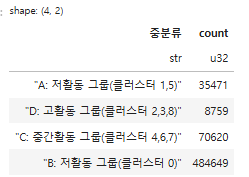

In [15]:
중분류_id_이름수정.shape

(599499, 2)

In [16]:
중분류_id_이름수정.write_csv('./dataset/중분류_id_이름수정.csv')

## CUSTOMER_N_2030_9 수정 -> 상품전체

### 상품전체_고객전체

In [17]:
CUSTOMER_N_2030_9

기준년월,고객ID,연령대,성별,고객등급,자택_시도,자택_시군구,수신_요구불예금,수신_거치식예금,수신_적립식예금,수신_펀드,수신_외화예금,대출금액,카드_사용횟수,카드_승인금액,카드_사용여부,KMeans_DB_KneeLocato_2030,중분류
i64,i64,str,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str
202101,9996691351,"""30대""","""남""","""일반등급""","""경상북도""","""성주군""",200000,0,0,0,0,0,0,0,0,0,"""B: 저활동 그룹(클러스터 0)"""
202101,9996689486,"""30대""","""여""","""일반등급""","""대구광역시""","""달서구""",34000000,0,0,0,0,0,0,0,0,3,"""D: 고활동 그룹(클러스터 2,3,8)"""
202101,9996680650,"""30대""","""여""","""일반등급""","""경상북도""","""구미시""",100000,0,0,0,0,0,0,0,0,0,"""B: 저활동 그룹(클러스터 0)"""
202101,9996676637,"""30대""","""여""","""일반등급""","""경상북도""","""구미시""",4300000,0,0,0,0,0,0,0,0,0,"""B: 저활동 그룹(클러스터 0)"""
202101,9996666899,"""30대""","""남""","""일반등급""","""경상북도""","""구미시""",3500000,0,400000,12000000,0,0,2,70000,1,0,"""B: 저활동 그룹(클러스터 0)"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
202312,2000399321,"""30대""","""남""","""일반등급""","""경상남도""","""고성군""",0,0,0,0,0,100000,0,0,0,0,"""B: 저활동 그룹(클러스터 0)"""
202312,2000393761,"""30대""","""남""","""일반등급""","""서울특별시""","""구로구""",0,0,0,0,0,100000,0,0,0,0,"""B: 저활동 그룹(클러스터 0)"""
202312,2000380811,"""30대""","""남""","""일반등급""","""경상북도""","""포항시 남구""",0,0,0,0,0,100000,0,0,0,0,"""B: 저활동 그룹(클러스터 0)"""


In [18]:
CUSTOMER_N_2030_9_중분류제거 = CUSTOMER_N_2030_9.drop("중분류")

In [19]:
CUSTOMER_N_2030_9_중분류제거

기준년월,고객ID,연령대,성별,고객등급,자택_시도,자택_시군구,수신_요구불예금,수신_거치식예금,수신_적립식예금,수신_펀드,수신_외화예금,대출금액,카드_사용횟수,카드_승인금액,카드_사용여부,KMeans_DB_KneeLocato_2030
i64,i64,str,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
202101,9996691351,"""30대""","""남""","""일반등급""","""경상북도""","""성주군""",200000,0,0,0,0,0,0,0,0,0
202101,9996689486,"""30대""","""여""","""일반등급""","""대구광역시""","""달서구""",34000000,0,0,0,0,0,0,0,0,3
202101,9996680650,"""30대""","""여""","""일반등급""","""경상북도""","""구미시""",100000,0,0,0,0,0,0,0,0,0
202101,9996676637,"""30대""","""여""","""일반등급""","""경상북도""","""구미시""",4300000,0,0,0,0,0,0,0,0,0
202101,9996666899,"""30대""","""남""","""일반등급""","""경상북도""","""구미시""",3500000,0,400000,12000000,0,0,2,70000,1,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
202312,2000399321,"""30대""","""남""","""일반등급""","""경상남도""","""고성군""",0,0,0,0,0,100000,0,0,0,0
202312,2000393761,"""30대""","""남""","""일반등급""","""서울특별시""","""구로구""",0,0,0,0,0,100000,0,0,0,0
202312,2000380811,"""30대""","""남""","""일반등급""","""경상북도""","""포항시 남구""",0,0,0,0,0,100000,0,0,0,0


In [20]:
df_joined_inner_상품전체_고객전체 = (
    CUSTOMER_N_2030_9_중분류제거
    .join(
        중분류_id_이름수정.select(["고객ID", "중분류"]).unique(),
        on="고객ID",
        how="inner"
    )
)

In [21]:
df_joined_inner_상품전체_고객전체

기준년월,고객ID,연령대,성별,고객등급,자택_시도,자택_시군구,수신_요구불예금,수신_거치식예금,수신_적립식예금,수신_펀드,수신_외화예금,대출금액,카드_사용횟수,카드_승인금액,카드_사용여부,KMeans_DB_KneeLocato_2030,중분류
i64,i64,str,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str
202101,9996691351,"""30대""","""남""","""일반등급""","""경상북도""","""성주군""",200000,0,0,0,0,0,0,0,0,0,"""A"""
202101,9996689486,"""30대""","""여""","""일반등급""","""대구광역시""","""달서구""",34000000,0,0,0,0,0,0,0,0,3,"""D"""
202101,9996680650,"""30대""","""여""","""일반등급""","""경상북도""","""구미시""",100000,0,0,0,0,0,0,0,0,0,"""A"""
202101,9996676637,"""30대""","""여""","""일반등급""","""경상북도""","""구미시""",4300000,0,0,0,0,0,0,0,0,0,"""A"""
202101,9996666899,"""30대""","""남""","""일반등급""","""경상북도""","""구미시""",3500000,0,400000,12000000,0,0,2,70000,1,0,"""A"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
202312,2000399321,"""30대""","""남""","""일반등급""","""경상남도""","""고성군""",0,0,0,0,0,100000,0,0,0,0,"""A"""
202312,2000393761,"""30대""","""남""","""일반등급""","""서울특별시""","""구로구""",0,0,0,0,0,100000,0,0,0,0,"""A"""
202312,2000380811,"""30대""","""남""","""일반등급""","""경상북도""","""포항시 남구""",0,0,0,0,0,100000,0,0,0,0,"""A"""


In [22]:
print(CUSTOMER_N_2030_9.shape)
print(CUSTOMER_N_2030_9.shape[0])
print(len(CUSTOMER_N_2030_9['고객ID'].unique()))
print(중분류_id_이름수정.shape[0])
print(len(중분류_id_이름수정['고객ID']))
print(df_joined_inner_상품전체_고객전체.shape)
print(df_joined_inner_상품전체_고객전체.shape[0])
print(len(df_joined_inner_상품전체_고객전체['고객ID']))
print(len(df_joined_inner_상품전체_고객전체['고객ID'].unique()))

(18373952, 18)
18373952
599499
599499
599499
(18373952, 18)
18373952
18373952
599499


In [23]:
CUSTOMER_N_2030_9['중분류'].value_counts()

중분류,count
str,u32
"""A: 저활동 그룹(클러스터 1,5)""",817124
"""C: 중간활동 그룹(클러스터 4,6,7)""",2482677
"""D: 고활동 그룹(클러스터 2,3,8)""",284027
"""B: 저활동 그룹(클러스터 0)""",14790124


In [24]:
df_joined_inner_상품전체_고객전체['중분류'].value_counts()

중분류,count
str,u32
"""B""",817124
"""D""",284027
"""C""",2482677
"""A""",14790124


In [25]:
df_joined_inner_상품전체_고객전체.write_csv('./dataset/상품전체_고객전체.csv')

In [26]:
상품전체_고객전체 = pl.read_csv('./dataset/상품전체_고객전체.csv')

In [27]:
상품전체_고객전체

기준년월,고객ID,연령대,성별,고객등급,자택_시도,자택_시군구,수신_요구불예금,수신_거치식예금,수신_적립식예금,수신_펀드,수신_외화예금,대출금액,카드_사용횟수,카드_승인금액,카드_사용여부,KMeans_DB_KneeLocato_2030,중분류
i64,i64,str,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str
202101,9996691351,"""30대""","""남""","""일반등급""","""경상북도""","""성주군""",200000,0,0,0,0,0,0,0,0,0,"""A"""
202101,9996689486,"""30대""","""여""","""일반등급""","""대구광역시""","""달서구""",34000000,0,0,0,0,0,0,0,0,3,"""D"""
202101,9996680650,"""30대""","""여""","""일반등급""","""경상북도""","""구미시""",100000,0,0,0,0,0,0,0,0,0,"""A"""
202101,9996676637,"""30대""","""여""","""일반등급""","""경상북도""","""구미시""",4300000,0,0,0,0,0,0,0,0,0,"""A"""
202101,9996666899,"""30대""","""남""","""일반등급""","""경상북도""","""구미시""",3500000,0,400000,12000000,0,0,2,70000,1,0,"""A"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
202312,2000399321,"""30대""","""남""","""일반등급""","""경상남도""","""고성군""",0,0,0,0,0,100000,0,0,0,0,"""A"""
202312,2000393761,"""30대""","""남""","""일반등급""","""서울특별시""","""구로구""",0,0,0,0,0,100000,0,0,0,0,"""A"""
202312,2000380811,"""30대""","""남""","""일반등급""","""경상북도""","""포항시 남구""",0,0,0,0,0,100000,0,0,0,0,"""A"""


In [28]:
상품전체_고객전체['중분류'].value_counts()

중분류,count
str,u32
"""D""",284027
"""B""",817124
"""C""",2482677
"""A""",14790124


In [29]:
print(상품전체_고객전체.shape)
print(상품전체_고객전체.shape[0])
print(len(상품전체_고객전체['고객ID']))
print(len(상품전체_고객전체['고객ID'].unique()))

(18373952, 18)
18373952
18373952
599499


### 상품전체_고객집계

In [32]:
print(list(상품전체_고객전체.columns))

['기준년월', '고객ID', '연령대', '성별', '고객등급', '자택_시도', '자택_시군구', '수신_요구불예금', '수신_거치식예금', '수신_적립식예금', '수신_펀드', '수신_외화예금', '대출금액', '카드_사용횟수', '카드_승인금액', '카드_사용여부', 'KMeans_DB_KneeLocato_2030', '중분류']


In [40]:
def aggregate_customer_data_all(df: pl.DataFrame) -> pl.DataFrame:
    """
    고객 단위로 주요 금융 항목을 집계하여 요약 데이터를 생성합니다.

    처리 내용:
    1. '기준금리', '성별' 컬럼 제거
    2. 고객ID 기준 그룹화 후 다음과 같이 집계:
        - 입출금예금, 기타예금, 비이자상품, 카드, 대출, 총점수: 평균값
        - 거래기간(개월), 연령대: 최대값
        - 보유상품수:
            - 최대_보유상품종류: 최대값
            - 평균_보유상품종류: 평균값을 반올림 후 Int8 형으로 변환

    Parameters:
        df (pl.DataFrame): 원본 고객 월별 데이터

    Returns:
        pl.DataFrame: 고객ID 기준으로 집계된 요약 데이터프레임
    """

    df_agg = (
        df
        .group_by("고객ID")
        .agg([
            pl.col("수신_요구불예금").mean().alias("평균_수신_요구불금예금"),
            pl.col("수신_거치식예금").mean().alias("평균_수신_거치식예금"),
            pl.col("수신_적립식예금").mean().alias("평균_수신_적립식예금"),
            pl.col("수신_펀드").mean().alias("평균_수신_펀드"),
            pl.col("수신_외화예금").mean().alias("평균_수신_외화예금"),
            pl.col("대출금액").mean().alias("평균_대출금액"),
            pl.col("카드_사용횟수").mean().alias("평균_카드_사용횟수"),
            pl.col("카드_승인금액").mean().alias("평균_카드_승인금액"),
            pl.col("카드_사용여부").mean().alias("평균_카드_사용여부"),
            pl.col("연령대").max().alias("연령대"),
            pl.col("고객등급").max().alias("최대_고객등급"),
            # 클러스터 관련 컬럼 (대표값으로 유지)
            pl.col("KMeans_DB_KneeLocato_2030").first().alias("KMeans_DB_KneeLocato_2030"),
            pl.col("중분류").first().alias("중분류")
        ])
    )
    return df_agg

In [41]:
상품전체_고객전체_집계 = aggregate_customer_data_all(상품전체_고객전체)

In [42]:
상품전체_고객전체_집계

고객ID,평균_수신_요구불금예금,평균_수신_거치식예금,평균_수신_적립식예금,평균_수신_펀드,평균_수신_외화예금,평균_대출금액,평균_카드_사용횟수,평균_카드_승인금액,평균_카드_사용여부,연령대,최대_고객등급,KMeans_DB_KneeLocato_2030,중분류
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,i64,str
4634799869,0.0,0.0,5555.555556,0.0,0.0,0.0,18.555556,426944.444444,0.916667,"""20대""","""일반등급""",0,"""A"""
3857596621,361111.111111,0.0,0.0,0.0,0.0,0.0,3.75,76111.111111,0.805556,"""20대""","""일반등급""",0,"""A"""
2745893391,690909.090909,0.0,0.0,0.0,0.0,0.0,11.863636,531818.181818,0.818182,"""20대""","""일반등급""",0,"""A"""
2034216836,200000.0,0.0,0.0,0.0,0.0,2e6,0.0,0.0,0.0,"""30대""","""일반등급""",0,"""A"""
6164128312,83333.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""30대""","""일반등급""",0,"""A"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…
6588397292,7.5379e6,0.0,0.0,0.0,0.0,0.0,13.793103,814482.758621,1.0,"""30대""","""일반등급""",6,"""C"""
4107061582,297222.222222,0.0,2.5917e6,0.0,0.0,0.0,0.0,0.0,0.0,"""20대""","""일반등급""",0,"""A"""
3686251256,680555.555556,0.0,0.0,0.0,0.0,4.3083e6,2.277778,191666.666667,0.472222,"""30대""","""일반등급""",0,"""A"""


In [43]:
상품전체_고객전체_집계['중분류'].value_counts()

중분류,count
str,u32
"""A""",484649
"""C""",70620
"""D""",8759
"""B""",35471


In [44]:
상품전체_고객전체_집계.shape

(599499, 14)

In [45]:
상품전체_고객전체_집계.write_csv('./dataset/상품전체_고객집계.csv')

## CUSTOMER_SCORE_금리_9_2030_중분류 수정 -> 상품집계

### 상품집계_고객전체

In [46]:
CUSTOMER_SCORE_금리_9_2030_중분류

고객ID,기준년월,연령대,성별,고객등급,입출금예금,기타예금,비이자상품,카드,대출,기준금리,보유상품수,거래기간(개월),총점수,KMeans_DB_KneeLocato_2030,중분류
i64,i64,i64,str,str,i64,i64,i64,i64,i64,f64,i64,i64,f64,i64,str
9996691351,202106,30,"""남""","""일반등급""",2500000,0,0,0,0,4.55,1,6,231.333333,0,"""B: 저활동 그룹(클러스터 0)"""
9996689486,202106,30,"""여""","""일반등급""",17000000,0,0,340000,0,4.55,2,6,2029.666667,3,"""D: 고활동 그룹(클러스터 2,3,8)"""
9996680650,202106,30,"""여""","""일반등급""",100000,0,0,0,0,4.55,1,6,20.666667,0,"""B: 저활동 그룹(클러스터 0)"""
9996676637,202106,30,"""여""","""일반등급""",4900000,0,0,0,0,4.55,1,6,391.333333,0,"""B: 저활동 그룹(클러스터 0)"""
9996666899,202106,30,"""남""","""일반등급""",700000,4100000,9800000,0,0,4.55,3,6,815.333333,0,"""B: 저활동 그룹(클러스터 0)"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2000399321,202312,30,"""남""","""일반등급""",0,0,0,0,100000,9.18,1,1,17.991667,0,"""B: 저활동 그룹(클러스터 0)"""
2000393761,202312,30,"""남""","""일반등급""",0,0,0,0,100000,9.18,1,1,17.991667,0,"""B: 저활동 그룹(클러스터 0)"""
2000380811,202312,30,"""남""","""일반등급""",0,0,0,0,100000,9.18,1,1,17.991667,0,"""B: 저활동 그룹(클러스터 0)"""


In [47]:
CUSTOMER_SCORE_금리_9_2030_중분류제거 = CUSTOMER_SCORE_금리_9_2030_중분류.drop("중분류")

In [48]:
CUSTOMER_SCORE_금리_9_2030_중분류제거

고객ID,기준년월,연령대,성별,고객등급,입출금예금,기타예금,비이자상품,카드,대출,기준금리,보유상품수,거래기간(개월),총점수,KMeans_DB_KneeLocato_2030
i64,i64,i64,str,str,i64,i64,i64,i64,i64,f64,i64,i64,f64,i64
9996691351,202106,30,"""남""","""일반등급""",2500000,0,0,0,0,4.55,1,6,231.333333,0
9996689486,202106,30,"""여""","""일반등급""",17000000,0,0,340000,0,4.55,2,6,2029.666667,3
9996680650,202106,30,"""여""","""일반등급""",100000,0,0,0,0,4.55,1,6,20.666667,0
9996676637,202106,30,"""여""","""일반등급""",4900000,0,0,0,0,4.55,1,6,391.333333,0
9996666899,202106,30,"""남""","""일반등급""",700000,4100000,9800000,0,0,4.55,3,6,815.333333,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2000399321,202312,30,"""남""","""일반등급""",0,0,0,0,100000,9.18,1,1,17.991667,0
2000393761,202312,30,"""남""","""일반등급""",0,0,0,0,100000,9.18,1,1,17.991667,0
2000380811,202312,30,"""남""","""일반등급""",0,0,0,0,100000,9.18,1,1,17.991667,0


In [49]:
df_joined_inner_상품집계_고객전체 = (
    CUSTOMER_SCORE_금리_9_2030_중분류제거
    .join(
        중분류_id_이름수정.select(["고객ID", "중분류"]).unique(),
        on="고객ID",
        how="inner"
    )
)

In [50]:
df_joined_inner_상품집계_고객전체

고객ID,기준년월,연령대,성별,고객등급,입출금예금,기타예금,비이자상품,카드,대출,기준금리,보유상품수,거래기간(개월),총점수,KMeans_DB_KneeLocato_2030,중분류
i64,i64,i64,str,str,i64,i64,i64,i64,i64,f64,i64,i64,f64,i64,str
9996691351,202106,30,"""남""","""일반등급""",2500000,0,0,0,0,4.55,1,6,231.333333,0,"""A"""
9996689486,202106,30,"""여""","""일반등급""",17000000,0,0,340000,0,4.55,2,6,2029.666667,3,"""D"""
9996680650,202106,30,"""여""","""일반등급""",100000,0,0,0,0,4.55,1,6,20.666667,0,"""A"""
9996676637,202106,30,"""여""","""일반등급""",4900000,0,0,0,0,4.55,1,6,391.333333,0,"""A"""
9996666899,202106,30,"""남""","""일반등급""",700000,4100000,9800000,0,0,4.55,3,6,815.333333,0,"""A"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2000399321,202312,30,"""남""","""일반등급""",0,0,0,0,100000,9.18,1,1,17.991667,0,"""A"""
2000393761,202312,30,"""남""","""일반등급""",0,0,0,0,100000,9.18,1,1,17.991667,0,"""A"""
2000380811,202312,30,"""남""","""일반등급""",0,0,0,0,100000,9.18,1,1,17.991667,0,"""A"""


In [51]:
print(CUSTOMER_SCORE_금리_9_2030_중분류.shape[0])
print(len(CUSTOMER_SCORE_금리_9_2030_중분류['고객ID'].unique()))
print(중분류_id_이름수정.shape[0])
print(len(중분류_id_이름수정['고객ID']))
print(df_joined_inner_상품집계_고객전체.shape[0])
print(len(df_joined_inner_상품집계_고객전체['고객ID']))
print(len(df_joined_inner_상품집계_고객전체['고객ID'].unique()))

16063094
599499
599499
599499
16063094
16063094
599499


In [52]:
df_joined_inner_상품집계_고객전체.write_csv('./dataset/상품집계_고객전체.csv')

### 상품집계_고객집계

In [53]:
상품집계_고객전체 = pl.read_csv('./dataset/상품집계_고객전체.csv')

In [54]:
상품집계_고객전체

고객ID,기준년월,연령대,성별,고객등급,입출금예금,기타예금,비이자상품,카드,대출,기준금리,보유상품수,거래기간(개월),총점수,KMeans_DB_KneeLocato_2030,중분류
i64,i64,i64,str,str,i64,i64,i64,i64,i64,f64,i64,i64,f64,i64,str
9996691351,202106,30,"""남""","""일반등급""",2500000,0,0,0,0,4.55,1,6,231.333333,0,"""A"""
9996689486,202106,30,"""여""","""일반등급""",17000000,0,0,340000,0,4.55,2,6,2029.666667,3,"""D"""
9996680650,202106,30,"""여""","""일반등급""",100000,0,0,0,0,4.55,1,6,20.666667,0,"""A"""
9996676637,202106,30,"""여""","""일반등급""",4900000,0,0,0,0,4.55,1,6,391.333333,0,"""A"""
9996666899,202106,30,"""남""","""일반등급""",700000,4100000,9800000,0,0,4.55,3,6,815.333333,0,"""A"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2000399321,202312,30,"""남""","""일반등급""",0,0,0,0,100000,9.18,1,1,17.991667,0,"""A"""
2000393761,202312,30,"""남""","""일반등급""",0,0,0,0,100000,9.18,1,1,17.991667,0,"""A"""
2000380811,202312,30,"""남""","""일반등급""",0,0,0,0,100000,9.18,1,1,17.991667,0,"""A"""


In [55]:
def aggregate_customer_data(df: pl.DataFrame) -> pl.DataFrame:
    """
    고객 단위로 주요 금융 항목을 집계하여 요약 데이터를 생성합니다.

    처리 내용:
    1. '기준금리', '성별' 컬럼 제거
    2. 고객ID 기준 그룹화 후 다음과 같이 집계:
        - 입출금예금, 기타예금, 비이자상품, 카드, 대출, 총점수: 평균값
        - 거래기간(개월), 연령대: 최대값
        - 보유상품수:
            - 최대_보유상품종류: 최대값
            - 평균_보유상품종류: 평균값을 반올림 후 Int8 형으로 변환

    Parameters:
        df (pl.DataFrame): 원본 고객 월별 데이터

    Returns:
        pl.DataFrame: 고객ID 기준으로 집계된 요약 데이터프레임
    """
    df_dropped = df.drop(["기준금리", "성별"])

    df_agg = (
        df_dropped
        .group_by("고객ID")
        .agg([
            pl.col("입출금예금").mean().alias("평균_입출금예금"),
            pl.col("기타예금").mean().alias("평균_기타예금"),
            pl.col("비이자상품").mean().alias("평균_비이자상품"),
            pl.col("카드").mean().alias("평균_카드"),
            pl.col("대출").mean().alias("평균_대출금액"),
            pl.col("거래기간(개월)").max().alias("거래기간(개월)"),
            pl.col("총점수").mean().alias("평균_총점수"),
            pl.col("보유상품수").max().alias("최대_보유상품종류"),
            pl.col("보유상품수").mean().round(0).cast(pl.Int8).alias("평균_보유상품종류"),            
            pl.col("연령대").max().alias("연령대"),
            pl.col("고객등급").max().alias("최대_고객등급"),
            # 클러스터 관련 컬럼 (대표값으로 유지)
            pl.col("KMeans_DB_KneeLocato_2030").first().alias("KMeans_DB_KneeLocato_2030"),
            pl.col("중분류").first().alias("중분류")
        ])
    )
    return df_agg

In [56]:
상품집계_고객집계 = aggregate_customer_data(상품집계_고객전체)

In [57]:
상품집계_고객집계

고객ID,평균_입출금예금,평균_기타예금,평균_비이자상품,평균_카드,평균_대출금액,거래기간(개월),평균_총점수,최대_보유상품종류,평균_보유상품종류,연령대,최대_고객등급,KMeans_DB_KneeLocato_2030,중분류
i64,f64,f64,f64,f64,f64,i64,f64,i64,i8,i64,str,i64,str
2065204669,0.0,0.0,0.0,0.0,1.85e6,2,210.116667,1,1,30,"""일반등급""",0,"""A"""
4070774528,722580.645161,1.3355e6,0.0,1.0152e6,0.0,36,330.565591,3,2,20,"""일반등급""",0,"""A"""
4720215619,190322.580645,6451.612903,0.0,0.0,0.0,36,41.44086,2,1,30,"""일반등급""",0,"""A"""
4139190886,7.8290e6,0.0,0.0,6129.032258,0.0,36,655.55914,2,1,20,"""일반등급""",6,"""C"""
2243610603,200000.0,0.0,0.0,10000.0,5.65e6,6,1487.988889,3,2,20,"""일반등급""",0,"""A"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…
4412204367,122580.645161,0.0,0.0,510322.580645,0.0,36,132.941935,2,2,20,"""일반등급""",0,"""A"""
3925855257,54838.709677,0.0,0.0,0.0,0.0,36,19.333333,1,0,30,"""일반등급""",0,"""A"""
6829335805,1.8e6,0.0,0.0,0.0,0.0,36,166.580645,1,1,30,"""일반등급""",0,"""A"""


In [58]:
상품집계_고객집계.write_csv('./dataset/상품집계_고객집계.csv')

## cluster 파일

### cluster a -> cluster b

In [59]:
cluster_a_pl= pl.read_csv('dataset/cluster_a_pd.csv')

In [60]:
cluster_a_pl

,고객ID,수신_요구불예금,수신_거치식예금,수신_적립식예금,수신_펀드,수신_외화예금,대출금액,카드_사용여부,중분류,수신_요구불예금_상태,수신_거치식예금_상태,수신_적립식예금_상태,수신_펀드_상태,수신_외화예금_상태,대출금액_상태,카드_사용여부_상태
i64,i64,i64,i64,i64,i64,i64,i64,i64,str,str,str,str,str,str,str,str
0,6051244903,1,0,0,0,0,1,1,"""A: 저활동 그룹(클러스터 1,5)""","""수신_요구불예금-O""","""수신_거치식예금-X""","""수신_적립식예금-X""","""수신_펀드-X""","""수신_외화예금-X""","""대출금액-O""","""카드_사용여부-O"""
1,6051244903,1,0,0,0,0,1,1,"""A: 저활동 그룹(클러스터 1,5)""","""수신_요구불예금-O""","""수신_거치식예금-X""","""수신_적립식예금-X""","""수신_펀드-X""","""수신_외화예금-X""","""대출금액-O""","""카드_사용여부-O"""
2,6051244903,1,0,0,0,0,1,1,"""A: 저활동 그룹(클러스터 1,5)""","""수신_요구불예금-O""","""수신_거치식예금-X""","""수신_적립식예금-X""","""수신_펀드-X""","""수신_외화예금-X""","""대출금액-O""","""카드_사용여부-O"""
3,6051244903,1,0,0,0,0,1,1,"""A: 저활동 그룹(클러스터 1,5)""","""수신_요구불예금-O""","""수신_거치식예금-X""","""수신_적립식예금-X""","""수신_펀드-X""","""수신_외화예금-X""","""대출금액-O""","""카드_사용여부-O"""
4,6051244903,1,0,0,0,0,1,1,"""A: 저활동 그룹(클러스터 1,5)""","""수신_요구불예금-O""","""수신_거치식예금-X""","""수신_적립식예금-X""","""수신_펀드-X""","""수신_외화예금-X""","""대출금액-O""","""카드_사용여부-O"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
817119,4475044342,1,0,0,0,0,1,0,"""A: 저활동 그룹(클러스터 1,5)""","""수신_요구불예금-O""","""수신_거치식예금-X""","""수신_적립식예금-X""","""수신_펀드-X""","""수신_외화예금-X""","""대출금액-O""","""카드_사용여부-X"""
817120,4475044342,1,0,0,0,0,1,0,"""A: 저활동 그룹(클러스터 1,5)""","""수신_요구불예금-O""","""수신_거치식예금-X""","""수신_적립식예금-X""","""수신_펀드-X""","""수신_외화예금-X""","""대출금액-O""","""카드_사용여부-X"""
817121,4475044342,1,0,0,0,0,1,0,"""A: 저활동 그룹(클러스터 1,5)""","""수신_요구불예금-O""","""수신_거치식예금-X""","""수신_적립식예금-X""","""수신_펀드-X""","""수신_외화예금-X""","""대출금액-O""","""카드_사용여부-X"""


In [61]:
cluster_a_pl_이름수정 = cluster_a_pl.with_columns([
    pl.col("중분류")
    .str.replace_all("A: 저활동 그룹\\(클러스터 1,5\\)", "B")
    .str.replace_all("B: 저활동 그룹\\(클러스터 0\\)", "A")
    .str.replace_all("C: 중간활동 그룹\\(클러스터 4,6,7\\)", "C")
    .str.replace_all("D: 고활동 그룹\\(클러스터 2,3,8\\)", "D")
    .alias("중분류")
])

In [62]:
cluster_a_pl_이름수정.head()

,고객ID,수신_요구불예금,수신_거치식예금,수신_적립식예금,수신_펀드,수신_외화예금,대출금액,카드_사용여부,중분류,수신_요구불예금_상태,수신_거치식예금_상태,수신_적립식예금_상태,수신_펀드_상태,수신_외화예금_상태,대출금액_상태,카드_사용여부_상태
i64,i64,i64,i64,i64,i64,i64,i64,i64,str,str,str,str,str,str,str,str
0,6051244903,1,0,0,0,0,1,1,"""B""","""수신_요구불예금-O""","""수신_거치식예금-X""","""수신_적립식예금-X""","""수신_펀드-X""","""수신_외화예금-X""","""대출금액-O""","""카드_사용여부-O"""
1,6051244903,1,0,0,0,0,1,1,"""B""","""수신_요구불예금-O""","""수신_거치식예금-X""","""수신_적립식예금-X""","""수신_펀드-X""","""수신_외화예금-X""","""대출금액-O""","""카드_사용여부-O"""
2,6051244903,1,0,0,0,0,1,1,"""B""","""수신_요구불예금-O""","""수신_거치식예금-X""","""수신_적립식예금-X""","""수신_펀드-X""","""수신_외화예금-X""","""대출금액-O""","""카드_사용여부-O"""
3,6051244903,1,0,0,0,0,1,1,"""B""","""수신_요구불예금-O""","""수신_거치식예금-X""","""수신_적립식예금-X""","""수신_펀드-X""","""수신_외화예금-X""","""대출금액-O""","""카드_사용여부-O"""
4,6051244903,1,0,0,0,0,1,1,"""B""","""수신_요구불예금-O""","""수신_거치식예금-X""","""수신_적립식예금-X""","""수신_펀드-X""","""수신_외화예금-X""","""대출금액-O""","""카드_사용여부-O"""


In [64]:
cluster_a_pl_이름수정.write_csv('./dataset/cluster_b_상품조합.csv')

### cluster b -> cluster a

In [63]:
cluster_b_pl= pl.read_csv('dataset/cluster_b_pd.csv')

In [65]:
cluster_b_pl_이름수정 = cluster_b_pl.with_columns([
    pl.col("중분류")
    .str.replace_all("A: 저활동 그룹\\(클러스터 1,5\\)", "B")
    .str.replace_all("B: 저활동 그룹\\(클러스터 0\\)", "A")
    .str.replace_all("C: 중간활동 그룹\\(클러스터 4,6,7\\)", "C")
    .str.replace_all("D: 고활동 그룹\\(클러스터 2,3,8\\)", "D")
    .alias("중분류")
])

In [66]:
cluster_b_pl_이름수정.write_csv('./dataset/cluster_a_상품조합.csv')

### cluster c 

In [1]:
# 경고 메시지 무시
import warnings
warnings.filterwarnings("ignore")

# 한글 폰트 설정 (Matplotlib에서 한글 깨짐 방지)
import matplotlib.pyplot as plt

plt.rc("font", family="NanumGothic")  # Windows 사용자의 경우

# 마이너스 기호 깨짐 방지
plt.rcParams["axes.unicode_minus"] = False

# 기본 라이브러리
import polars as pl
import pandas as pd
import seaborn as sns
import numpy as np

# 시각화용 색상 팔레트
color_palette = sns.color_palette("Set2", as_cmap=False)

In [2]:
cluster_c_pl= pl.read_csv('dataset/cluster_c_pd.csv')

In [3]:
cluster_c_pl_이름수정 = cluster_c_pl.with_columns([
    pl.col("중분류")
    .str.replace_all("A: 저활동 그룹\\(클러스터 1,5\\)", "B")
    .str.replace_all("B: 저활동 그룹\\(클러스터 0\\)", "A")
    .str.replace_all("C: 중간활동 그룹\\(클러스터 4,6,7\\)", "C")
    .str.replace_all("D: 고활동 그룹\\(클러스터 2,3,8\\)", "D")
    .alias("중분류")
])

In [4]:
cluster_c_pl_이름수정.write_csv('./dataset/cluster_c_상품조합.csv')

cluster d

In [5]:
cluster_d_pl= pl.read_csv('dataset/cluster_d_pd.csv')

In [6]:
cluster_d_pl_이름수정 = cluster_d_pl.with_columns([
    pl.col("중분류")
    .str.replace_all("A: 저활동 그룹\\(클러스터 1,5\\)", "B")
    .str.replace_all("B: 저활동 그룹\\(클러스터 0\\)", "A")
    .str.replace_all("C: 중간활동 그룹\\(클러스터 4,6,7\\)", "C")
    .str.replace_all("D: 고활동 그룹\\(클러스터 2,3,8\\)", "D")
    .alias("중분류")
])

In [7]:
cluster_d_pl_이름수정.write_csv('./dataset/cluster_d_상품조합.csv')

## CUSTOMER_SCORE_금리_고객집계 만들기

In [1]:
# 경고 메시지 무시
import warnings
warnings.filterwarnings("ignore")

# 한글 폰트 설정 (Matplotlib에서 한글 깨짐 방지)
import matplotlib.pyplot as plt

plt.rc("font", family="NanumGothic")  # Windows 사용자의 경우

# 마이너스 기호 깨짐 방지
plt.rcParams["axes.unicode_minus"] = False

# 기본 라이브러리
import polars as pl
import pandas as pd
import seaborn as sns

# 시각화용 색상 팔레트
color_palette = sns.color_palette("Set2", as_cmap=False)

In [7]:
def aggregate_customer_data_no_cluster(df: pl.DataFrame) -> pl.DataFrame:
    """
    고객 단위로 주요 금융 항목을 집계하여 요약 데이터를 생성합니다.

    처리 내용:
    1. '기준금리', '성별' 컬럼 제거
    2. 고객ID 기준 그룹화 후 다음과 같이 집계:
        - 입출금예금, 기타예금, 비이자상품, 카드, 대출, 총점수: 평균값
        - 거래기간(개월), 연령대: 최대값
        - 보유상품수:
            - 최대_보유상품종류: 최대값
            - 평균_보유상품종류: 평균값을 반올림 후 Int8 형으로 변환

    Parameters:
        df (pl.DataFrame): 원본 고객 월별 데이터

    Returns:
        pl.DataFrame: 고객ID 기준으로 집계된 요약 데이터프레임
    """
    df_dropped = df.drop(["기준금리", "성별"])

    df_agg = (
        df_dropped
        .group_by("고객ID")
        .agg([
            pl.col("입출금예금").mean().alias("평균_입출금예금"),
            pl.col("기타예금").mean().alias("평균_기타예금"),
            pl.col("비이자상품").mean().alias("평균_비이자상품"),
            pl.col("카드").mean().alias("평균_카드"),
            pl.col("대출").mean().alias("평균_대출금액"),
            pl.col("거래기간(개월)").max().alias("거래기간(개월)"),
            pl.col("총점수").mean().alias("평균_총점수"),
            pl.col("보유상품수").max().alias("최대_보유상품종류"),
            pl.col("보유상품수").mean().round(0).cast(pl.Int8).alias("평균_보유상품종류"),            
            pl.col("연령대").max().alias("연령대"),
            pl.col("고객등급").max().alias("최대_고객등급"),
            # # 클러스터 관련 컬럼 (대표값으로 유지)
            # pl.col("KMeans_DB_KneeLocato_2030").first().alias("KMeans_DB_KneeLocato_2030"),
            # pl.col("중분류").first().alias("중분류")
        ])
    )
    return df_agg

In [2]:
df = pl.read_csv('./dataset/CUSTOMER_SCORE_금리.csv')

In [3]:
df.head()

고객ID,기준년월,연령대,성별,고객등급,입출금예금,기타예금,비이자상품,카드,대출,기준금리,보유상품수,거래기간(개월),총점수
i64,i64,i64,str,str,i64,i64,i64,i64,i64,f64,i64,i64,f64
9999998161,202106,60,"""여""","""일반등급""",11000000,0,0,60000,0,4.55,2,6,1040.533333
9999997589,202106,60,"""남""","""일반등급""",0,10400000,0,0,0,4.55,2,6,436.0
9999991579,202106,60,"""여""","""일반등급""",0,30000000,0,0,0,4.55,1,6,1210.0
9999989448,202106,60,"""남""","""일반등급""",400000,0,0,0,0,4.55,1,6,42.0
9999988325,202106,60,"""남""","""일반등급""",2700000,0,0,0,0,4.55,1,6,178.0


In [8]:
CUSTOMER_SCORE_금리_고객집계 = aggregate_customer_data_no_cluster(df)

In [9]:
CUSTOMER_SCORE_금리_고객집계

고객ID,평균_입출금예금,평균_기타예금,평균_비이자상품,평균_카드,평균_대출금액,거래기간(개월),평균_총점수,최대_보유상품종류,평균_보유상품종류,연령대,최대_고객등급
i64,f64,f64,f64,f64,f64,i64,f64,i64,i8,i64,str
8029049273,277419.354839,0.0,0.0,0.0,0.0,36,45.204301,1,1,60,"""일반등급"""
7217905638,516129.032258,0.0,0.0,1.2819e6,0.0,36,298.589247,2,2,40,"""일반등급"""
6357187164,683870.967742,0.0,0.0,18709.677419,5.5581e6,36,2071.695161,3,1,30,"""일반등급"""
5830406301,706451.612903,2.8065e6,0.0,645.16129,0.0,36,194.67957,3,2,30,"""일반등급"""
7438371436,5.3548e6,6.1065e7,0.0,0.0,0.0,36,2925.870968,3,3,50,"""일반등급"""
…,…,…,…,…,…,…,…,…,…,…,…
2420614211,36363.636364,0.0,0.0,0.0,2.2455e6,11,841.6,2,1,50,"""일반등급"""
2335333204,2.3125e6,0.0,0.0,828750.0,0.0,8,306.841667,2,2,30,"""일반등급"""
5226342813,0.0,5.7194e6,0.0,0.0,0.0,36,247.913978,2,2,20,"""일반등급"""


In [10]:
print(len(df['고객ID'].unique()))
print(CUSTOMER_SCORE_금리_고객집계.shape[0])

1978693
1978693


In [11]:
CUSTOMER_SCORE_금리_고객집계.write_csv('./dataset/CUSTOMER_SCORE_금리_고객집계.csv')